In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_metric = pd.read_csv("kinase_drug_activity.csv", index_col = 0)

In [3]:
df_metric.head()

,Kinase,Kinase_official,Kinase_group,5278396,6605258,2044,9817165,5719375,65399,135398501,...,10113978,160355,216239,5329102,3038522,9926791,5494449,3081361,151194,10341154
1,ABL1,ABL1,TK,99.523181,101.156070,59.828521,80.364374,96.729602,99.854936,98.202267,...,63.697560,102.203440,90.433806,47.242063,103.992358,100.918552,13.755904,11.737212,96.518775,99.670558
2,ABL2/ARG,ABL2,TK,92.003595,104.833625,57.117112,100.179730,95.744601,101.810358,96.773605,...,38.472576,100.254267,99.372587,61.779072,96.987201,90.507367,5.745228,14.009564,100.625970,100.004858
3,ACK1,TNK2,TK,95.668218,97.958749,93.122893,99.983316,97.995206,92.507167,92.287431,...,90.165015,96.675470,97.602167,64.110336,92.687278,87.074426,66.426616,85.373276,91.659723,96.103732
4,AKT1,AKT1,AGC,113.075577,117.842860,108.237754,114.350814,103.929535,108.226994,114.147466,...,91.172589,90.347601,96.168540,104.828767,102.414287,90.266579,99.193846,94.703990,102.972800,84.718889
5,AKT2,AKT2,AGC,96.036526,91.566042,97.710727,91.500197,99.632088,107.109725,96.791523,...,107.137395,102.005980,102.648283,87.360113,97.909978,98.025346,103.226246,110.183971,103.994331,118.275569


# Network Analysis of All Kinases

We will define whether the inhibition-driven links between kinases will cause the kinases to cluster by kinase groups based on genetic similarity.  In other words, We will explore whether kinases which are having similar genetic background are targeted by similar inhibitor sets.

## Obtain Active Flags

Generally, if the activation value of kinase inhibited by a molecule is less than 25, it is considered that the kinase is inhibited.

Let's get active flags for the analysis.

In [4]:
colList = list(df_metric.columns)

In [5]:
colList.remove('Kinase')
colList.remove('Kinase_official')
colList.remove('Kinase_group')

In [6]:
def getActive(value):
    if value < 10 :
        return(1) # Inhibited: 1
    else :
        return(0) # Not Inhibited: 0

In [7]:
for col in colList:
    df_metric[col] = df_metric[col].apply(getActive)

In [8]:
df_metric.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            291, 292, 293, 294, 295, 296, 297, 298, 299, 300],
           dtype='int64', length=300)

In [9]:
df_metric.head()

,Kinase,Kinase_official,Kinase_group,5278396,6605258,2044,9817165,5719375,65399,135398501,...,10113978,160355,216239,5329102,3038522,9926791,5494449,3081361,151194,10341154
1,ABL1,ABL1,TK,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ABL2/ARG,ABL2,TK,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,ACK1,TNK2,TK,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AKT1,AKT1,AGC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,AKT2,AKT2,AGC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_kinase = df_metric.drop(['Kinase','Kinase_group'], axis = 1)
df_kinase = df_kinase.set_index('Kinase_official')
df_kinase = df_kinase.transpose()

In [11]:
df_kinase.head()

Kinase_official,ABL1,ABL2,TNK2,AKT1,AKT2,AKT3,ALK,ACVRL1,ACVR1,ACVR1B,...,ULK2,ULK3,VRK1,WEE1,WNK2,WNK3,YES1,ZAK,ZAP70,DAPK3
5278396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6605258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9817165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5719375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate Network

We measure the **weights** of each network between kinases by counts **how many effective inhibitors they shared**. 

In [12]:
tuples = []
for i, kinase1 in enumerate(df_kinase.columns):
    for j, kinase2 in enumerate(df_kinase.columns):
        if i > j:
            if df_kinase[(df_kinase[kinase1] == 1) & (df_kinase[kinase2] == 1)].shape[0] > 0 :
                temp = (kinase1,kinase2,{"weight":df_kinase[(df_kinase[kinase1] == 1) & (df_kinase[kinase2] == 1)].shape[0]})
                tuples.append(temp)

In [13]:
import networkx as nx
kinases=nx.Graph()

# Adding edges will automatically add nodes.
kinases.add_edges_from(tuples)

In [14]:
# Adding additional information of nodes.
nodes = df_metric[['Kinase_official','Kinase_group']]

# Adding attributes to the nodes in the graph.
for node in nodes['Kinase_official']:
    if node in kinases.nodes():
        kinases.node[node]['class'] = nodes.loc[nodes['Kinase_official']==node,'Kinase_group'].values[0]

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


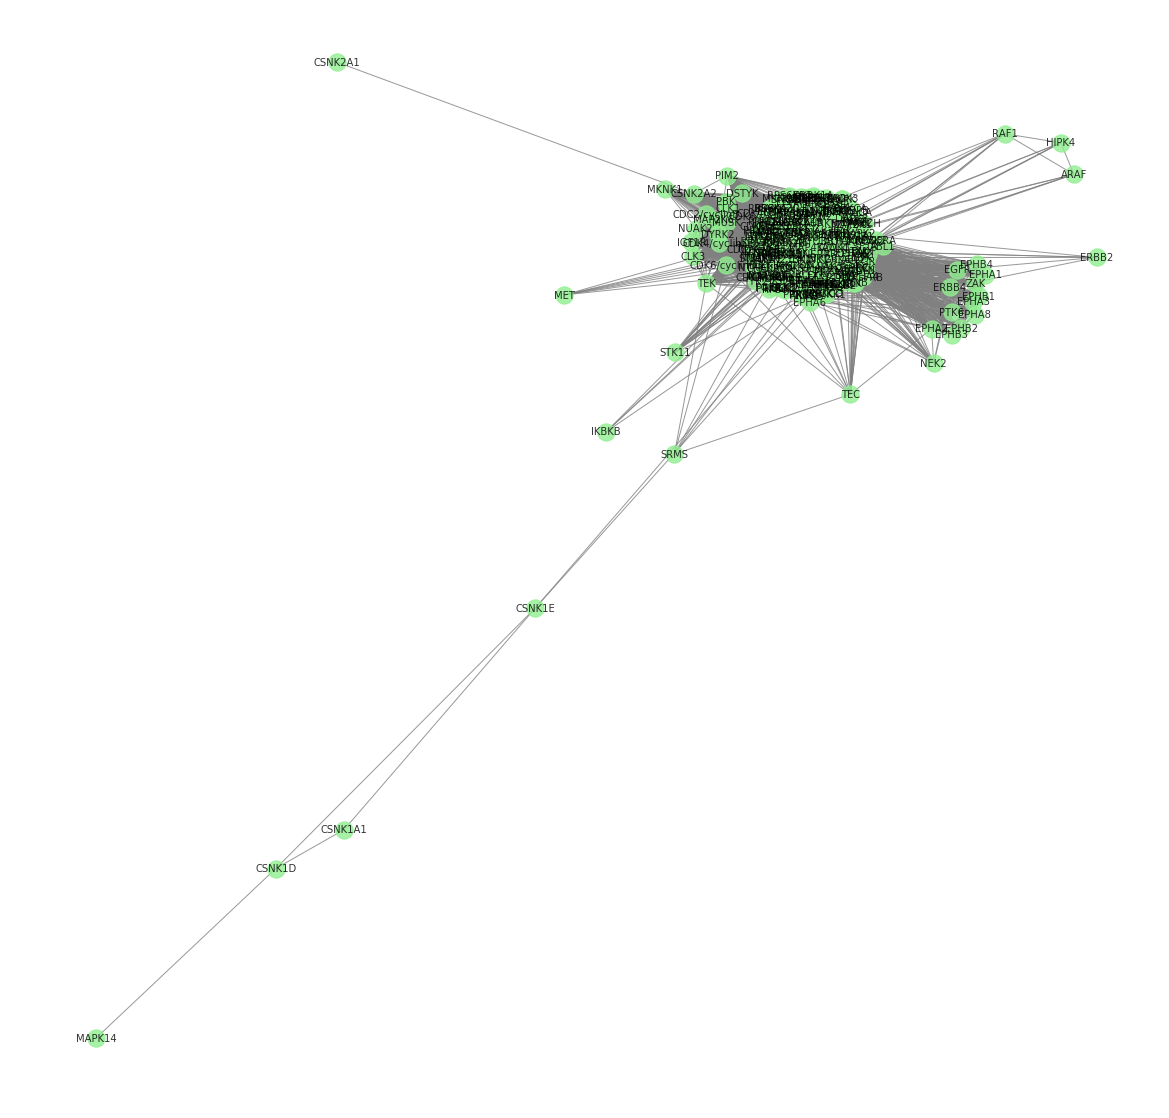

In [15]:
plt.rcParams['figure.figsize']=[20,20]
nx.draw_networkx(kinases,
                 pos=nx.spring_layout(kinases,weight='weights'), 
                 node_color='lightgreen',
                 edge_color='gray',
                 node_size=300,
                 with_labels=True,
                 font_size=10,
                 alpha=.8
                 )
plt.axis('off')
plt.show()

This graph has 235 nodes and 20209 edges.
The median degree is 198.0 and the mean degree is 171.99148936170212.
A kinase node with median degree is connected to 84.25531914893617% of other kinase.
There are 1 connected components within the graph.


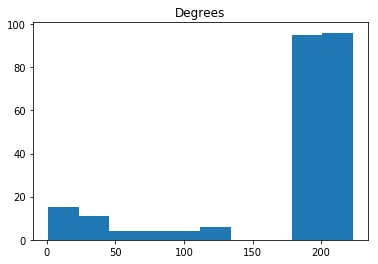

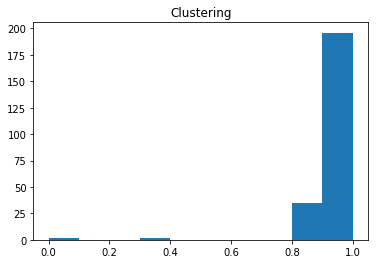

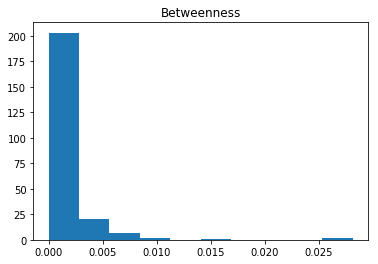

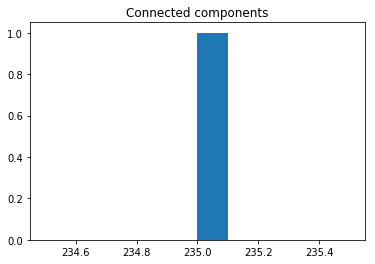

In [16]:
numberofnodes=kinases.number_of_nodes()
nodedegrees=list(dict(kinases.degree).values())
av_degree=np.mean(nodedegrees)
med_degree=np.median(nodedegrees)
clustering=list(nx.clustering(kinases).values())
betweenness_cent=list(nx.betweenness_centrality(kinases).values())
componentsizes=[len(c) for c in sorted(
    nx.connected_components(kinases), key=len, reverse=True)]

print("This graph has {} nodes and {} edges.".format(
    kinases.number_of_nodes(),kinases.number_of_edges()))

print("The median degree is {} and the mean degree is {}.".format(med_degree,av_degree))

print("A kinase node with median degree is connected to {}% of other kinase.".format(
    (med_degree/numberofnodes)*100))

print("There are {} connected components within the graph.".format(
    nx.number_connected_components(kinases)))

plt.rcParams['figure.figsize']=[6,4]

plt.hist(nodedegrees)
plt.title('Degrees')
plt.show()

plt.hist(clustering)
plt.title('Clustering')
plt.show()

plt.hist(betweenness_cent)
plt.title('Betweenness')
plt.show()

plt.hist(componentsizes)
plt.title('Connected components')
plt.show()

In [17]:
# Pulling our node-level statistics together into a dataframe.
graph_stats=pd.DataFrame({'node':list(dict(kinases.degree()).keys()),
                          'degree':list(dict(kinases.degree()).values()),
                          'clustering':list(nx.clustering(kinases).values()),
                          'betweenness_cent':list(
                              nx.betweenness_centrality(kinases).values())
                         })

# Assigning each node to a component by number.
graph_stats['component']=None

# Sorting the components by size so that the largest component will be numbered 0.
components=sorted(nx.connected_components(kinases), key=len, reverse=True)
for i,component in enumerate(components):
    graph_stats.loc[graph_stats['node'].isin(list(component)),'component']=i
    
print(graph_stats.head())
    

   node  degree  clustering  betweenness_cent  component
0  ABL2     204    0.891336          0.003075          0
1  ABL1     119    0.816978          0.002274          0
2  TNK2     223    0.804266          0.028144          0
3  AKT1     190    1.000000          0.000000          0
4  AKT2     190    1.000000          0.000000          0


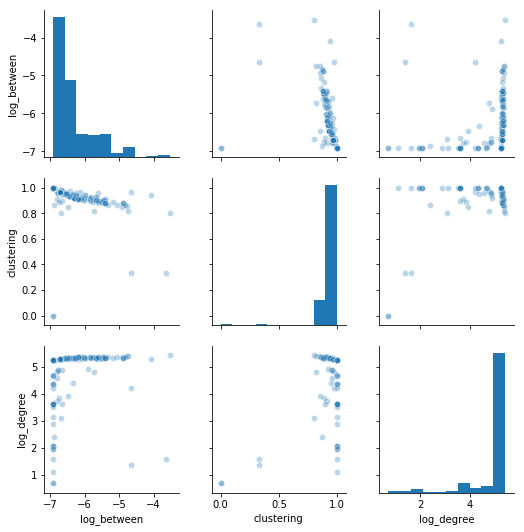

In [18]:
# Logging these two for easier relationship viewing.
graph_stats['log_between']=np.log(graph_stats['betweenness_cent']+.001)
graph_stats['log_degree']=np.log(graph_stats['degree']+1)

g = sns.pairplot(graph_stats,
                 vars=['log_between','clustering','log_degree'],
                 kind='scatter',
                plot_kws={'alpha':.3})
plt.show()

## Statistics of Network

As shown in the degree histogram, most nodes are connected to many other nodes, though the degrees are skewed into the left side. In the clustering histogram, we can see most of the kinases cluster very tightly (> 0.75).

Though this network seems highly connected, betweenness centrality scores are low overall. Moreover, we can see only 1 connected component in the network.

In [19]:
# Merging our statistics with the original node information.
kinases_stats=pd.merge(graph_stats,nodes,left_on='node',right_on='Kinase_official',how='inner')

      node  degree  clustering  betweenness_cent  component  log_between  \
220  NTRK1     203    0.930888          0.002021          0    -5.802272   
221  NTRK2     202    0.939855          0.000909          0    -6.260988   
222  NTRK3     209    0.897957          0.002616          0    -5.622372   
223  TSSK2     190    1.000000          0.000000          0    -6.907755   
224    TXK     205    0.886657          0.004612          0    -5.182892   
225    LTK     199    0.957972          0.000436          0    -6.545921   
226   TYK2     208    0.905007          0.003223          0    -5.467322   
227  TYRO3     190    1.000000          0.000000          0    -6.907755   
228   ULK1     201    0.941194          0.001507          0    -5.988728   
229   ULK2     204    0.933787          0.000573          0    -6.454706   
230   ULK3     198    0.966210          0.000224          0    -6.705567   
231   YES1     205    0.883453          0.003473          0    -5.409739   
232    ZAK  

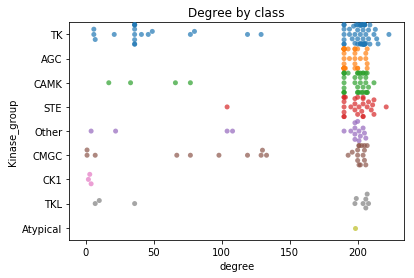

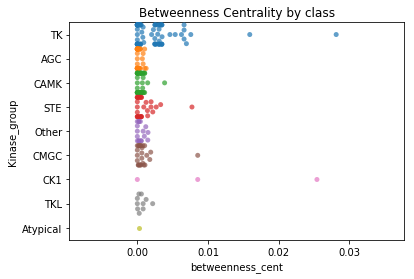

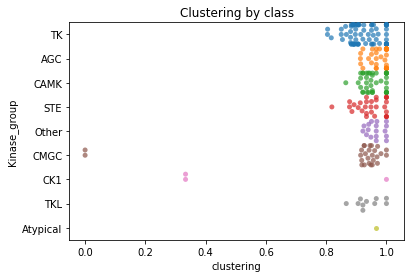

In [20]:
# Plotting node stats by class

sns.swarmplot(x="degree", y="Kinase_group", data=kinases_stats,alpha=.7)
plt.title('Degree by class')
plt.show()

sns.swarmplot(x="betweenness_cent", y="Kinase_group", data=kinases_stats,alpha=.7)
plt.title('Betweenness Centrality by class')
plt.show()

sns.swarmplot(x="clustering", y="Kinase_group", data=kinases_stats,alpha=.7)
plt.title('Clustering by class')
plt.show()

## Classes and node characteristics
Most of the kinases have high degrees. 
 This suggests that most of the kinases tend to share the many inhibitors targeting them regardless of which group they belong to. Because we used the kinase inhibitors in this analysis, the results are not surprising. However, what we should notice is that many inhibitors are targeting multiple kinases.

Betweenness centralities are low. None of the kinase groups seem particularly likely to have nodes with high betweenness centrality.

Clustering seems to be all kinases are clustered together.


In [21]:
print('The number of nodes in each class:')
nodesbyclass=kinases_stats.groupby(by='Kinase_group')['component'].count()
print(nodesbyclass)

print('\nThe number of connected components that members of each class belong to.')
componentsbyclass=kinases_stats.groupby(by='Kinase_group')['component'].apply(
    lambda x: len(set(x)))
print(componentsbyclass)

#A class with more nodes has more opportunities to belong to multiple components, so we'll divide by number of nodes.
print("\nNumber of components by class normalized by number of nodes.")
print(componentsbyclass/nodesbyclass)

The number of nodes in each class:
Kinase_group
AGC         37
Atypical     1
CAMK        40
CK1          3
CMGC        26
Other       17
STE         29
TK          72
TKL         10
Name: component, dtype: int64

The number of connected components that members of each class belong to.
Kinase_group
AGC         1
Atypical    1
CAMK        1
CK1         1
CMGC        1
Other       1
STE         1
TK          1
TKL         1
Name: component, dtype: int64

Number of components by class normalized by number of nodes.
Kinase_group
AGC         0.027027
Atypical    1.000000
CAMK        0.025000
CK1         0.333333
CMGC        0.038462
Other       0.058824
STE         0.034483
TK          0.013889
TKL         0.100000
Name: component, dtype: float64


# Network Analysis of All Kinases (Colored by Kinase Group)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


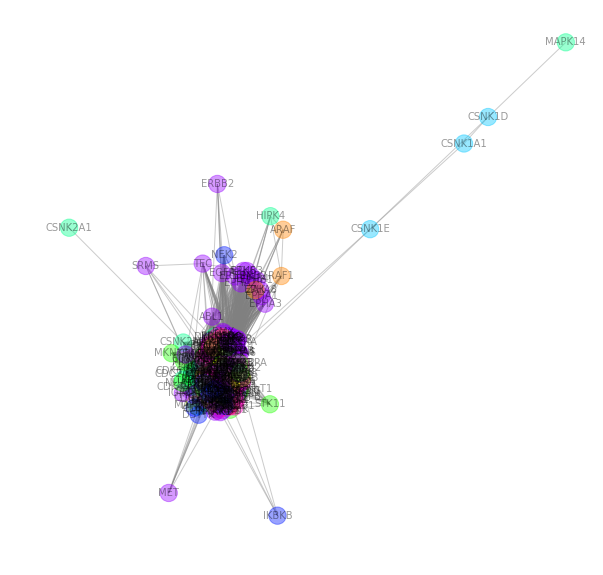

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Getting a list of all the nodes' classes, in order
classlist=list(nx.get_node_attributes(kinases,'class').values())

#Creating a dictionary associating each class with a unique integer.
classes=set(classlist)
dictionary=dict(zip(classes,range(len(classes))))

#Creating a list of integers corresponding to classes to use for color assignment.
classcolors=[dictionary[x] for x in classlist]

plt.rcParams['figure.figsize']=[10,10]
        
nx.draw_networkx(kinases,
                 pos=nx.spring_layout(kinases,weight='weights'), 
                 cmap=plt.get_cmap('gist_rainbow'), 
                 node_color=classcolors,
                 edge_color='gray',
                 node_size=300,
                 with_labels=True,
                 font_size=10,
                 alpha=.4
                 )
plt.axis('off')

plt.show()

## Sumamry

From the network graphs above, we can see most kinases are in-network and the few of kinase sub-clusters are a little bit separated.

EPH receptor kinases (EPHXXs) and Epidermal growth factor receptor family (EGFR, ERBB2, ERBB4, RAF1, ARAF, etc) seem clustered together and they located close to each other. The distance between kinases in the graph means that the network weight, in other words, how many inhibitors they are sharing.

Also, we can observe tyrosine kinase (TK) group and tyrosine kinase-like (TKL) group are slightly clustered together than others.

# Network Analysis of Tyrosine Kinases (TK) and Tyrosine Kinases Like (TKL)

In [23]:
df_TK = df_metric[(df_metric['Kinase_group'] =='TK') | (df_metric['Kinase_group'] =='TKL')]

In [24]:
df_TK = df_TK.drop(['Kinase','Kinase_group'], axis = 1)
df_TK = df_TK.set_index('Kinase_official')
df_TK = df_TK.transpose()
df_TK.head()

Kinase_official,ABL1,ABL2,TNK2,ALK,ACVRL1,ACVR1,ACVR1B,TGFBR1,ARAF,AXL,...,NTRK1,NTRK2,NTRK3,TXK,LTK,TYK2,TYRO3,YES1,ZAK,ZAP70
5278396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6605258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9817165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5719375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
tuples = []
for kinase1 in df_TK.columns:
    for kinase2 in df_TK.columns:
        if kinase1 != kinase2:
            if df_kinase[(df_TK[kinase1] == 1) & (df_TK[kinase2] == 1)].shape[0] > 0 :
                temp = (kinase1,kinase2,{"weight":df_TK[(df_TK[kinase1] == 1) & (df_TK[kinase2] == 1)].shape[0]})
            
                tuples.append(temp)

In [26]:
nodes = df_metric[(df_metric['Kinase_group'] =='TK') | (df_metric['Kinase_group'] =='TKL')][['Kinase_official','Kinase_group']]
nodes.head()

,Kinase_official,Kinase_group
1,ABL1,TK
2,ABL2,TK
3,TNK2,TK
7,ALK,TK
8,ACVRL1,TKL


In [27]:
tyrosine=nx.Graph()

# Adding edges will automatically add nodes.
tyrosine.add_edges_from(tuples)

In [28]:
# Adding attributes to the nodes in the graph.
for node in nodes['Kinase_official']:
    if node in tyrosine.nodes():
        tyrosine.node[node]['class'] = nodes.loc[nodes['Kinase_official']==node,'Kinase_group'].values[0]

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


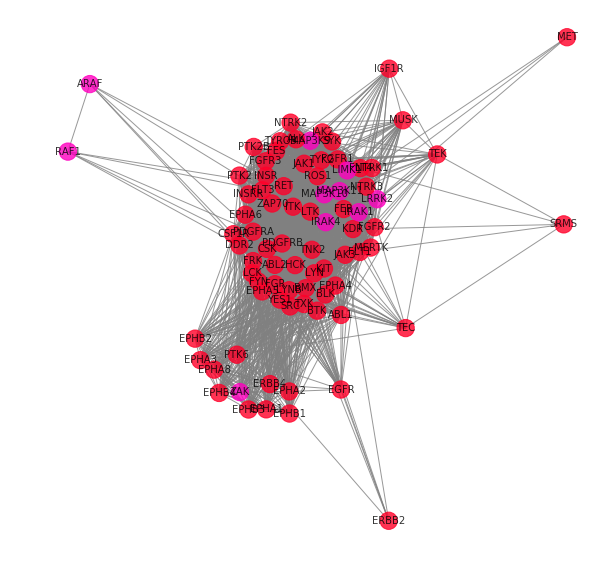

In [29]:
# Getting a list of all the nodes' c0lasses, in order
classlist=list(nx.get_node_attributes(tyrosine,'class').values())

#Creating a dictionary associating each class with a unique integer.
classes=set(classlist)
dictionary=dict(zip(classes,range(len(classes))))

#Creating a list of integers corresponding to classes to use for color assignment.
classcolors=[dictionary[x] for x in classlist]

plt.rcParams['figure.figsize']=[10,10]
        
nx.draw_networkx(tyrosine,
                 pos=nx.spring_layout(tyrosine,weight='weights'), 
                 cmap=plt.get_cmap('gist_rainbow'), 
                 node_color=classcolors,
                 edge_color='gray',
                 node_size=300,
                 with_labels=True,
                 font_size=10,
                 alpha=.8
                 )
plt.axis('off')

plt.show()

## Sumamry

According to this graph, the kinases have similar genetic components, they tend to be targeted by similar inhibitor sets.